In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install datasets
from datasets import load_dataset
#Research questions:
#Out of domain improvements? English/Spanish/Etc
# Load the XSum dataset
xsum_dataset = load_dataset("xsum")
xsum_test = xsum_dataset['test']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
##Get Log-likelihood
import torch

def get_log_likelihood(text,model_ll,tokenizer_ll):
  with torch.no_grad():
      tokenized = tokenizer_ll(text, return_tensors="pt")
      labels = tokenized.input_ids
      ll = -model_ll(**tokenized, labels=labels).loss.item()
      return ll




In [ ]:
def generate_text(text,generate_tokenizer,generate_model):
  # Define your prompt

  prompt = " ".join(text.split()[:30])
  # Tokenize the prompt
  inputs = generate_tokenizer(prompt, return_tensors="pt")

  # Generate text
  output = generate_model.generate(
      inputs.input_ids,
      max_length=300,  # Adjust the length as needed
      temperature=0.7,  # Adjust the temperature for more or less randomness
      top_k=50,  # Adjust for diversity
      top_p=0.95,  # Adjust for diversity
      do_sample=True,
      num_return_sequences=1  # Number of sequences to generate
  )

  # Decode the generated output
  generated_text = generate_tokenizer.decode(output[0], skip_special_tokens=True)
  return generated_text


In [ ]:

from random import sample

def mask_text(text, mask_percentage):
    # Tokenize the text into words
    words = text.split()

    # Calculate the number of two-word samples to mask
    num_samples_to_mask = int(len(words) * mask_percentage / 2)

    # Create a copy of the words list to avoid modifying the original text
    masked_text = words.copy()

    # Generate indices of two-word samples to mask
    indices_to_mask = sample(range(len(words) - 1), num_samples_to_mask)

    # Mask out the selected two-word samples
    for index in indices_to_mask:
        masked_text[index] = "[MASK]"
        masked_text[index + 1] = "[MASK]"

    # Join the masked words back into a sentence
    masked_sentence = " ".join(masked_text)

    return masked_sentence

# Example text
text = "Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation. Workers at the charity claim investment."


In [ ]:
#### POS Masking

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag, RegexpParser
nltk.download('punkt')  # Download the Punkt tokenizer models
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


def Mask_Noun_Verb_Phrase(document,noun_phrase_type = True,Replacement = 0.15):
  # Tokenize the sentence
  tokens = word_tokenize(document)

  # Perform part-of-speech tagging
  tagged_tokens = pos_tag(tokens)

  # Define a chunking grammar
  grammar = r"""
    NP: {<DT>?<JJ>*<NN>}  # Noun Phrase
    VP: {<VB.*><NP|PP>*}  # Verb Phrase
  """

  # Create a chunk parser
  chunk_parser = RegexpParser(grammar)

  # Apply chunking
  parsed_sentence = chunk_parser.parse(tagged_tokens)

  # Extract Noun Phrases and Verb Phrases
  noun_phrases = []
  verb_phrases = []

  for subtree in parsed_sentence.subtrees():
      if subtree.label() == 'NP':
          noun_phrases.append(" ".join(word for word, tag in subtree.leaves()))

      elif subtree.label() == 'VP':
          verb_phrases.append(" ".join(word for word, tag in subtree.leaves()))



  if noun_phrase_type:
    num_phrases_to_replace = int(len(noun_phrases) * Replacement)
    phrases_to_replace = sample(noun_phrases, num_phrases_to_replace)
  else:
    num_phrases_to_replace = int(len(verb_phrases) * Replacement)
    phrases_to_replace = sample(verb_phrases, num_phrases_to_replace)

    # Replace selected phrases with <MASK>
  masked_document = document
  for phrase in phrases_to_replace:
      masked_document = masked_document.replace(phrase, "[MASK]")



  return masked_document




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForMaskedLM


def generate_filled_text(masked_text,masked_model,masked_tokenizer):


    # Tokenize the masked text
    tokenized_text = masked_tokenizer(masked_text, return_tensors="pt")

    # Mask filling pipeline
    fill_mask = pipeline("fill-mask", model=masked_model, tokenizer=masked_tokenizer)

    # Generate predictions for masked tokens
    filled_text = masked_text
    for prediction in fill_mask(masked_text):
        filled_text = filled_text.replace("[MASK]", prediction[0]["token_str"], 1)

    return filled_text




In [ ]:
import matplotlib.pyplot as plt

# Define the data

def plot_histogram(human,ai,model,Sampling,bins = 10):
  # Set the number of bins
  num_bins = bins

  # Create the histogram
  plt.hist(human, bins=num_bins, alpha=0.5, label='human')
  plt.hist(ai, bins=num_bins, alpha=0.5, label='ai')

  # Add labels and title
  plt.xlabel(f'Log Probability Change of model {model} with {Sampling}')
  plt.ylabel('Frequency')
  plt.title('Histogram LL')

  ###Largest difference qualitative look
  ###Does curve get closer as model gets larger?
  ###LLama 7b 13b w quantization/ possibly 30b?
  ###different spans within the text noun phrases vs verbs
  ###paraphrasing model - paraphrase the human or ai text how much change does it work?
  ###paraphrasing paper
  ###QUALITATIVE EXAMPLES
  ##Spoofing attacks
  ##Binocular papers
  ##Survy paper pick a niche

  # Add legend
  plt.legend()

  # Show the plot
  plt.show()

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd


def calculate_log_probabilities(tokenizer_ll, model_ll,
                                masked_model,masked_tokenizer,
                                generate_tokenizer,generate_model,
                                iterations,percent,random = True,noun_phrase = False):
  """
  Arguments:
    tokenizer_ll --> tokenizer for the log loss calculation model
    model_ll --> log loss calculation model
    masked_model --> model for filling masked tokens
    masked_tokenizer --> tokenizer for filling masked tokens
    generate_tokenizer --> tokenizer for generating text
    generate_model --> model for generating text
    iterations --> number of iterations to run
    percent --> percent of text to be masked
    top_n_qualitative_samples --> keep the top n scores for qualitative samples
    random --> if True, randomly sample 15% of bigrams for masking otherwise apply noun phrase or verb phrase
    noun_phrase --> if True and random False, apply noun phrase masking otherwise apply verb phrase masking
    model --> model name to display in histogram chart

  Returns:
    human --> list of human scores
    ai --> list of ai scores
    top_n_qualitative_samples --> Actual Texts for differences

  """
  human = []
  ai = []
  top_samples = pd.DataFrame(columns = ['human/ai','score','original_text','filled_text'])
  for i in range(iterations):


    #Pull Data from Xsum dataset
    text = xsum_test[i]['document']

    #Set to less than 512 tokens
    text = " ".join(text.split()[:350])

    #Generate Text from first 350 words
    generated_text = generate_text(text,generate_tokenizer,generate_model)

    #If chosen randomly sample %percent of bigrams
    if random:
        masked_test_text = mask_text(text, percent)
        masked_generated_text = mask_text(generated_text, percent)

    #Else do Noun/Verb Phrase Sampling
    else:

      masked_test_text = Mask_Noun_Verb_Phrase(text, noun_phrase, percent)
      masked_generated_text = Mask_Noun_Verb_Phrase(generated_text, noun_phrase, percent)


    #Fill original text
    filled_test_text = generate_filled_text(masked_test_text,masked_tokenizer = masked_tokenizer,masked_model=masked_model)


    #Fill Generated Text
    filled_generated_text = generate_filled_text(masked_generated_text,masked_tokenizer = masked_tokenizer,masked_model=masked_model)



    #Calculate Log Probabilities
    humanscore = get_log_likelihood(text,model_ll,tokenizer_ll) - get_log_likelihood(filled_test_text,model_ll,tokenizer_ll)
    aiscore = get_log_likelihood(generated_text,model_ll,tokenizer_ll) - get_log_likelihood(filled_generated_text,model_ll,tokenizer_ll)

    top_samples.loc[len(top_samples)] = ['human',humanscore,text,filled_test_text]
    top_samples.loc[len(top_samples)] = ['ai',aiscore,generated_text,filled_generated_text]

    human.append(humanscore)
    ai.append(aiscore)


    print(i)


  return human,ai,top_samples



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


24


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


25


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


27


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


29


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


31


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


34


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


41


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


42


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


47


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


49


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


50


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


51


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


52


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


55


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


56


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


57


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


59


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


60


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


61


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


62


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


64


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


65


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


67


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


69


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


70


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


71


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


72


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


74


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


75


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


76


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


77


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


79


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


80


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


81


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


82


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


84


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


85


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


86


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


87


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


89


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


90


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


91


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


92


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


95


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


97


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


98
99


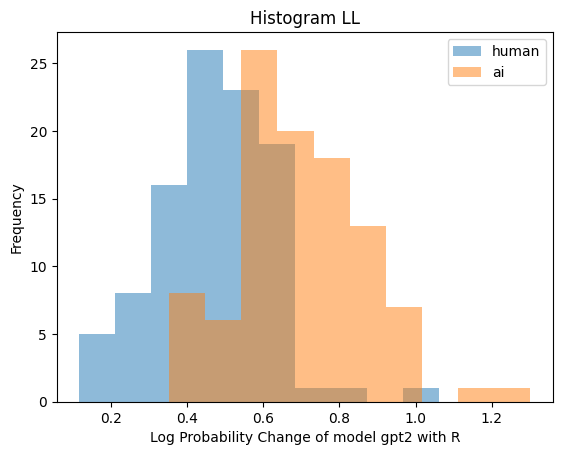

In [ ]:
generate_model_name = "gpt2"
masked_model_name = "bert-base-uncased"
model_ll_name = "gpt2"
Sampling = 'R'
if Sampling == 'R':
  random = True
  noun_phrase = False
elif Sampling == 'NP':
  random = False
  noun_phrase = True
elif Sampling == 'VP':
  random = False
  noun_phrase = False

###Largest difference qualitative look
###Does curve get closer as model gets larger?
###LLama 7b 13b w quantization/ possibly 30b?
###different spans within the text noun phrases vs verbs
###paraphrasing model - paraphrase the human or ai text how much change does it work?
###paraphrasing paper
###QUALITATIVE EXAMPLES
##Spoofing attacks
##Binocular papers
##Survy paper pick a niche

generate_tokenizer = AutoTokenizer.from_pretrained(generate_model_name)
generate_model = AutoModelForCausalLM.from_pretrained(generate_model_name)
masked_tokenizer = AutoTokenizer.from_pretrained(masked_model_name)
masked_model = AutoModelForCausalLM.from_pretrained(masked_model_name)
tokenizer_ll = AutoTokenizer.from_pretrained(model_ll_name)
model_ll = AutoModelForCausalLM.from_pretrained(model_ll_name)



human,ai,top_n_qualitative = calculate_log_probabilities(tokenizer_ll,model_ll,
                                                         masked_model,masked_tokenizer,
                                                         generate_tokenizer,generate_model,
                                                         100,0.15,random = random,noun_phrase = noun_phrase)
plot_histogram(human,ai,generate_model_name,Sampling)

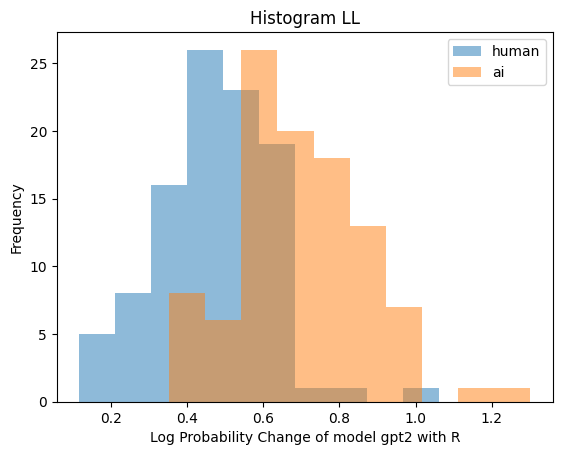

In [ ]:
plot_histogram(human,ai,generate_model_name,Sampling)
top_n_qualitative.to_csv(f'/content/drive/MyDrive/Top_N_Qualitative_Model_ll:{model_ll_name},generate_model:{generate_model_name},masked_model:{masked_model_name}.csv')


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


7


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


8


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


9


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


12


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


13


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


21


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


22


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


23


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


24


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


25


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


26


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


27


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


28


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


29


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


30


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


31


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


32


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


33


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


34


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


35


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


36


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


37


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


38


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


39


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


40


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


41


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


42


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


43


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


44


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


45


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


47


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


48


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


49


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


50


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


51


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


52


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


53


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


54


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


55


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


56


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


57


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


58


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


59


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


60


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


61


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


62


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


63


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


64


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


65


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


66


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


67


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


68


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


69


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


70


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


71


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


72


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


73


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


74


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


75


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


76


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


77


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


78


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


79


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


80


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


81


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


82


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


83


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


84


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


85


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


86


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


87


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


88


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


89


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


90


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


91


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


92


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


93


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


94


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


95


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


96


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


97


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


98
99


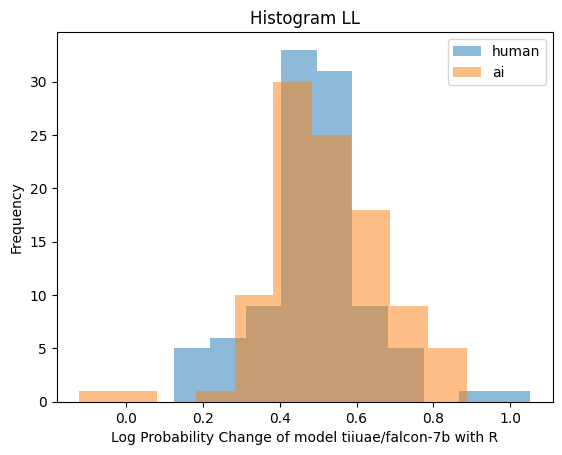

In [ ]:
generate_model_name = "tiiuae/falcon-7b"
masked_model_name = "bert-base-uncased"
model_ll_name = "gpt2"
Sampling = 'R'
iterations = 100
percent = 0.15

if Sampling == 'R':
  random = True
  noun_phrase = False
elif Sampling == 'NP':
  random = False
  noun_phrase = True
elif Sampling == 'VP':
  random = False
  noun_phrase = False

###Largest difference qualitative look
###Does curve get closer as model gets larger?
###LLama 7b 13b w quantization/ possibly 30b?
###different spans within the text noun phrases vs verbs
###paraphrasing model - paraphrase the human or ai text how much change does it work?
###paraphrasing paper
###QUALITATIVE EXAMPLES
##Spoofing attacks
##Binocular papers
##Survy paper pick a niche

generate_tokenizer = AutoTokenizer.from_pretrained(generate_model_name)
generate_model = AutoModelForCausalLM.from_pretrained(generate_model_name)
masked_tokenizer = AutoTokenizer.from_pretrained(masked_model_name)
masked_model = AutoModelForCausalLM.from_pretrained(masked_model_name)
tokenizer_ll = AutoTokenizer.from_pretrained(model_ll_name)
model_ll = AutoModelForCausalLM.from_pretrained(model_ll_name)



human,ai,top_n_qualitative = calculate_log_probabilities(tokenizer_ll,model_ll,
                                                         masked_model,masked_tokenizer,
                                                         generate_tokenizer,generate_model,
                                                         iterations,percent,random = random,noun_phrase = noun_phrase)
plot_histogram(human,ai,generate_model_name,Sampling)

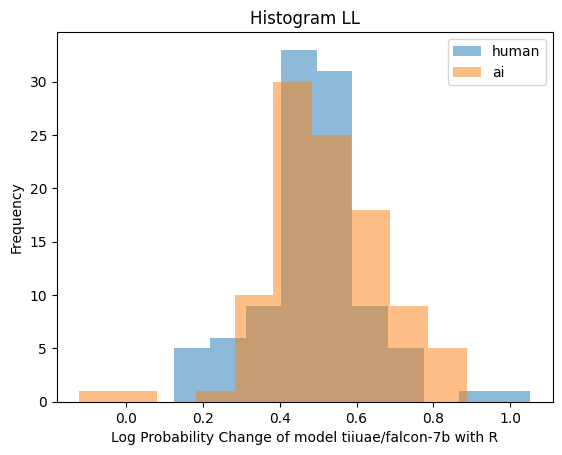

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Top_N_Qualitative_Model_ll:gpt2,generate_model:tiiuae'

In [ ]:
plot_histogram(human,ai,generate_model_name,Sampling)
top_n_qualitative.to_csv(f'/content/drive/MyDrive/Top_N_Qualitative_Model_ll:{model_ll_name},generate_model:{generate_model_name},masked_model:{masked_model_name}.csv')


In [ ]:
generate_model_name = "facebook/opt-1.3b"
masked_model_name = "bert-base-uncased"
model_ll_name = "gpt2"
Sampling = 'R'
iterations = 100
percent = 0.15

if Sampling == 'R':
  random = True
  noun_phrase = False
elif Sampling == 'NP':
  random = False
  noun_phrase = True
elif Sampling == 'VP':
  random = False
  noun_phrase = False

###Largest difference qualitative look
###Does curve get closer as model gets larger?
###LLama 7b 13b w quantization/ possibly 30b?
###different spans within the text noun phrases vs verbs
###paraphrasing model - paraphrase the human or ai text how much change does it work?
###paraphrasing paper
###QUALITATIVE EXAMPLES
##Spoofing attacks
##Binocular papers
##Survy paper pick a niche

generate_tokenizer = AutoTokenizer.from_pretrained(generate_model_name)
generate_model = AutoModelForCausalLM.from_pretrained(generate_model_name)
masked_tokenizer = AutoTokenizer.from_pretrained(masked_model_name)
masked_model = AutoModelForCausalLM.from_pretrained(masked_model_name)
tokenizer_ll = AutoTokenizer.from_pretrained(model_ll_name)
model_ll = AutoModelForCausalLM.from_pretrained(model_ll_name)


human,ai,top_n_qualitative = calculate_log_probabilities(tokenizer_ll,model_ll,
                                                         masked_model,masked_tokenizer,
                                                         generate_tokenizer,generate_model,
                                                         iterations,percent,random = random,noun_phrase = noun_phrase)
plot_histogram(human,ai,model_ll_name,Sampling)

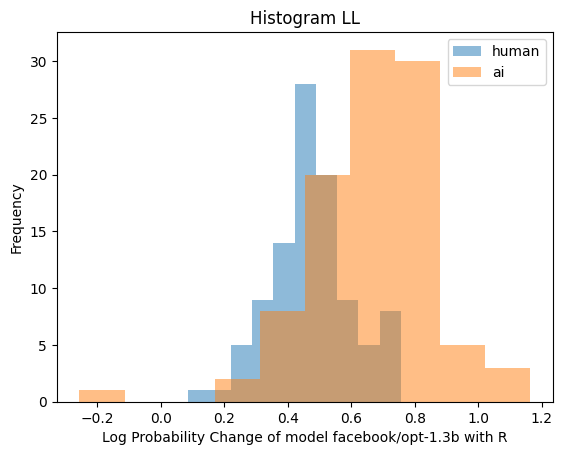

In [ ]:
plot_histogram(human,ai,generate_model_name,Sampling)
top_n_qualitative.to_csv(f'/content/drive/MyDrive/Top_N_Qualitative_Model_ll:{model_ll_name},generate_model:{"opt 1.3b"},masked_model:{"Bert"}.csv')


In [ ]:
top_scores = top_n_qualitative.groupby(['human/ai'],as_index=False)['score'].max()
top_scores = top_n_qualitative.loc[top_n_qualitative['score'].isin(top_scores['score'])]
for i in range(len(top_scores)):
  print('***************\nHuman/AI:',top_scores.iloc[i]['human/ai'],
        '\n***************\n-----------------\nOriginal Text:\n',
        top_scores.iloc[i]['original_text'],
        '\n------------\n----------Filled Text:\n',
        top_scores.iloc[i]['filled_text'])

***************
Human/AI: ai 
***************
-----------------
Original Text:
 Emily Thornberry said Labour would not "frustrate Brexit" even if it failed to amend the bill. Ten shadow ministers were among 47 Labour MPs who rejected party orders to back the amendment in the Commons.

The amendment, tabled by Labour MP Hilary Benn, would have required the government to seek a second referendum if the current deal was not ratified by MPs.

It would also have forced the government to put forward an amendment to the legislation that would have enshrined the results of the referendum in law.

The government has said it would seek a second referendum if the current deal was not approved by MPs.

The prime minister has said he would "not be drawn" on whether he would back such an amendment.

Image copyright PA Image caption Hilary Benn tabled the amendment

Labour has previously said it is ready to back such an amendment if it is put forward by the government.

The government has said it is 

In [ ]:
top_scores = top_n_qualitative.groupby(['human/ai'],as_index=False)['score'].min()
top_scores = top_n_qualitative.loc[top_n_qualitative['score'].isin(top_scores['score'])]
for i in range(len(top_scores)):
  print('***************\nHuman/AI:',top_scores.iloc[i]['human/ai'],
        '\n***************\n-----------------\nOriginal Text:\n',
        top_scores.iloc[i]['original_text'],
        '\n------------\n----------Filled Text:\n',
        top_scores.iloc[i]['filled_text'])

***************
Human/AI: ai 
***************
-----------------
Original Text:
 The 33-year-old takes over the role from Charlotte Burton, whom he assisted last season alongside his coaching commitments at Brighton College. Seamer Anyon took 199 wickets in 63 first-class appearances for the Seagulls, while former New Zealand international Matt Henry has been appointed batting coach. 
------------
----------Filled Text:
 The 33-year-old takes over the role from Charlotte Burton, whom he assisted last season alongside his former years at Brighton College. burton burton took 199 wickets in 63 first-class matches for the Seagulls, while former New Zealand international Matt Henry has been appointed batting coach.
***************
Human/AI: human 
***************
-----------------
Original Text:
 Causanagh Road, Loughgall Tannyoky Road, Poyntzpass Carrowreagh Road, Dundonald Edenticullo Road, Hillsborough New Line Road, Rathfriland Drumanure Road, Derrygonnelly 
------------
----------Filled

In [ ]:
gpt_top_n = pd.read_csv('/content/drive/MyDrive/Top_N_Qualitative_Model_ll:gpt2,generate_model:gpt2,masked_model:bert-base-uncased.csv')

In [ ]:
#In domain vs out of domain for Training
#Zero shot/detection log probabiltiy/entropy/perplxiety

#RADAR Paper - slides/technical details/implementation
#AI - alignment related

#Hallucination uncertainty - Fact Check? does the LLM tend to hallucainte similar to how detectGPT noticed a tendency towards negative curavture for AI text
#Map back to AI generated content

#Fact checking/Hallucination literature
#RADAR
#Fine tuning detection - graph based?
#Adversarial attacks? how do you engineer the data to poison the data?
#

In [ ]:
top_scores = gpt_top_n.groupby(['human/ai'],as_index=False)['score'].max()
top_scores = gpt_top_n.loc[gpt_top_n['score'].isin(top_scores['score'])]
for i in range(len(top_scores)):
  print('***************\nHuman/AI:',top_scores.iloc[i]['human/ai'],'score:',top_scores.iloc[i]['score'],
        '\n***************\n-----------------\nOriginal Text:\n',
        top_scores.iloc[i]['original_text'],
        '\n------------\n----------Filled Text:\n',
        top_scores.iloc[i]['filled_text'])

***************
Human/AI: ai score: 1.3012253046035769 
***************
-----------------
Original Text:
 But the latest Cinderella is bucking the trend - and seemingly appealing to audiences as a result. Directed by Sir Kenneth Branagh, Cinderella is a live-action version of Disney's classic fairy tale.

The film, which is set in a time when the royal family is in hiding, is set in the early 1900s, when a group of British aristocrats are captured and forced to be sold to the British Empire.

The film's cast and crew includes Emma Watson, Anne Hathaway, Robin Williams, Emma Watson, Lupita Nyong'o, Al Pacino, and the cast includes:

• Richard Gere, Anne Hathaway, Robin Williams, Emma Watson, Lupita Nyong'o, and Thomas Middleditch.

• James Blunt, Edward Norton, Mark Rylance, and Peter Dinklage.

• Paul Newman, Stephen Fry, George Clooney, and John Malkovich.

• Michael Douglas, Bill Murray, and Robert De Niro.

• Robert Redford.

• Martin Freeman, Stephen Fry, Al Pacino, and Peter Dinkl

Changes

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load pre-trained T5 model and tokenizer
model_name = "t5-small"  # You can choose other variants like "t5-base", "t5-large", etc.
paraphrase_model = T5ForConditionalGeneration.from_pretrained(model_name)
paraphrase_tokenizer = T5Tokenizer.from_pretrained(model_name)

# Example input text
input_text = "translate English to French: How are you?"

# Tokenize input text
input_ids = paraphrase_tokenizer.encode(input_text, return_tensors="pt")

# Generate translation
translated_ids = paraphrase_model.generate(input_ids)

# Decode translated tokens
translated_text = paraphrase_tokenizer.decode(translated_ids[0], skip_special_tokens=True)

# Print translated text
print("Translated text:", translated_text)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Translated text: Comment êtes-vous?


In [ ]:
"""
---DetectGPT code snippet---

import matplotlib.pyplot as plt
import numpy as np
import datasets
import transformers
import re
import torch
import torch.nn.functional as F
import tqdm
import random
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import argparse
import datetime
import os
import json
import functools
import custom_datasets
from multiprocessing.pool import ThreadPool
import time







def tokenize_and_mask(text, span_length, pct, ceil_pct=False):
    tokens = text.split(' ')
    mask_string = '<<<mask>>>'

    n_spans = pct * len(tokens) / (span_length + args.buffer_size * 2)
    if ceil_pct:
        n_spans = np.ceil(n_spans)
    n_spans = int(n_spans)

    n_masks = 0
    while n_masks < n_spans:
        start = np.random.randint(0, len(tokens) - span_length)
        end = start + span_length
        search_start = max(0, start - args.buffer_size)
        search_end = min(len(tokens), end + args.buffer_size)
        if mask_string not in tokens[search_start:search_end]:
            tokens[start:end] = [mask_string]
            n_masks += 1

    # replace each occurrence of mask_string with <extra_id_NUM>, where NUM increments
    num_filled = 0
    for idx, token in enumerate(tokens):
        if token == mask_string:
            tokens[idx] = f'<extra_id_{num_filled}>'
            num_filled += 1
    assert num_filled == n_masks, f"num_filled {num_filled} != n_masks {n_masks}"
    text = ' '.join(tokens)
    return text


def count_masks(texts):
    return [len([x for x in text.split() if x.startswith("<extra_id_")]) for text in texts]


# replace each masked span with a sample from T5 mask_model
def replace_masks(texts):
    n_expected = count_masks(texts)
    stop_id = mask_tokenizer.encode(f"<extra_id_{max(n_expected)}>")[0]
    tokens = mask_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
    outputs = mask_model.generate(**tokens, max_length=150, do_sample=True, top_p=args.mask_top_p, num_return_sequences=1, eos_token_id=stop_id)
    return mask_tokenizer.batch_decode(outputs, skip_special_tokens=False)


def extract_fills(texts):
    # remove <pad> from beginning of each text
    texts = [x.replace("<pad>", "").replace("</s>", "").strip() for x in texts]

    # return the text in between each matched mask token
    extracted_fills = [pattern.split(x)[1:-1] for x in texts]

    # remove whitespace around each fill
    extracted_fills = [[y.strip() for y in x] for x in extracted_fills]

    return extracted_fills


def apply_extracted_fills(masked_texts, extracted_fills):
    # split masked text into tokens, only splitting on spaces (not newlines)
    tokens = [x.split(' ') for x in masked_texts]

    n_expected = count_masks(masked_texts)

    # replace each mask token with the corresponding fill
    for idx, (text, fills, n) in enumerate(zip(tokens, extracted_fills, n_expected)):
        if len(fills) < n:
            tokens[idx] = []
        else:
            for fill_idx in range(n):
                text[text.index(f"<extra_id_{fill_idx}>")] = fills[fill_idx]

    # join tokens back into text
    texts = [" ".join(x) for x in tokens]
    return texts


def perturb_texts_(texts, span_length, pct, ceil_pct=False):
    if not args.random_fills:
        masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for x in texts]
        raw_fills = replace_masks(masked_texts)
        extracted_fills = extract_fills(raw_fills)
        perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)

        # Handle the fact that sometimes the model doesn't generate the right number of fills and we have to try again
        attempts = 1
        while '' in perturbed_texts:
            idxs = [idx for idx, x in enumerate(perturbed_texts) if x == '']
            print(f'WARNING: {len(idxs)} texts have no fills. Trying again [attempt {attempts}].')
            masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for idx, x in enumerate(texts) if idx in idxs]
            raw_fills = replace_masks(masked_texts)
            extracted_fills = extract_fills(raw_fills)
            new_perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)
            for idx, x in zip(idxs, new_perturbed_texts):
                perturbed_texts[idx] = x
            attempts += 1
    else:
        if args.random_fills_tokens:
            # tokenize base_tokenizer
            tokens = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
            valid_tokens = tokens.input_ids != base_tokenizer.pad_token_id
            replace_pct = args.pct_words_masked * (args.span_length / (args.span_length + 2 * args.buffer_size))

            # replace replace_pct of input_ids with random tokens
            random_mask = torch.rand(tokens.input_ids.shape, device=DEVICE) < replace_pct
            random_mask &= valid_tokens
            random_tokens = torch.randint(0, base_tokenizer.vocab_size, (random_mask.sum(),), device=DEVICE)
            # while any of the random tokens are special tokens, replace them with random non-special tokens
            while any(base_tokenizer.decode(x) in base_tokenizer.all_special_tokens for x in random_tokens):
                random_tokens = torch.randint(0, base_tokenizer.vocab_size, (random_mask.sum(),), device=DEVICE)
            tokens.input_ids[random_mask] = random_tokens
            perturbed_texts = base_tokenizer.batch_decode(tokens.input_ids, skip_special_tokens=True)
        else:
            masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for x in texts]
            perturbed_texts = masked_texts
            # replace each <extra_id_*> with args.span_length random words from FILL_DICTIONARY
            for idx, text in enumerate(perturbed_texts):
                filled_text = text
                for fill_idx in range(count_masks([text])[0]):
                    fill = random.sample(FILL_DICTIONARY, span_length)
                    filled_text = filled_text.replace(f"<extra_id_{fill_idx}>", " ".join(fill))
                assert count_masks([filled_text])[0] == 0, "Failed to replace all masks"
                perturbed_texts[idx] = filled_text

    return perturbed_texts


def perturb_texts(texts, span_length, pct, ceil_pct=False):
    chunk_size = args.chunk_size
    if '11b' in mask_filling_model_name:
        chunk_size //= 2

    outputs = []
    for i in tqdm.tqdm(range(0, len(texts), chunk_size), desc="Applying perturbations"):
        outputs.extend(perturb_texts_(texts[i:i + chunk_size], span_length, pct, ceil_pct=ceil_pct))
    return outputs


def drop_last_word(text):
    return ' '.join(text.split(' ')[:-1])


def _openai_sample(p):
    return p + r['choices'][0].text


# sample from base_model using ****only**** the first 30 tokens in each example as context
def sample_from_model(texts, min_words=55, prompt_tokens=30):
    # encode each text as a list of token ids
    if args.dataset == 'pubmed':
        texts = [t[:t.index(custom_datasets.SEPARATOR)] for t in texts]
        all_encoded = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
    else:
        all_encoded = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
        all_encoded = {key: value[:, :prompt_tokens] for key, value in all_encoded.items()}

    if args.openai_model:
        # decode the prefixes back into text
        prefixes = base_tokenizer.batch_decode(all_encoded['input_ids'], skip_special_tokens=True)
        pool = ThreadPool(args.batch_size)

        decoded = pool.map(_openai_sample, prefixes)
    else:
        decoded = ['' for _ in range(len(texts))]

        # sample from the model until we get a sample with at least min_words words for each example
        # this is an inefficient way to do this (since we regenerate for all inputs if just one is too short), but it works
        tries = 0
        while (m := min(len(x.split()) for x in decoded)) < min_words:
            if tries != 0:
                print()
                print(f"min words: {m}, needed {min_words}, regenerating (try {tries})")

            sampling_kwargs = {}
            if args.do_top_p:
                sampling_kwargs['top_p'] = args.top_p
            elif args.do_top_k:
                sampling_kwargs['top_k'] = args.top_k
            min_length = 50 if args.dataset in ['pubmed'] else 150
            outputs = base_model.generate(**all_encoded, min_length=min_length, max_length=200, do_sample=True, **sampling_kwargs, pad_token_id=base_tokenizer.eos_token_id, eos_token_id=base_tokenizer.eos_token_id)
            decoded = base_tokenizer.batch_decode(outputs, skip_special_tokens=True)
            tries += 1

    if args.openai_model:
        global API_TOKEN_COUNTER

        # count total number of tokens with GPT2_TOKENIZER
        total_tokens = sum(len(GPT2_TOKENIZER.encode(x)) for x in decoded)
        API_TOKEN_COUNTER += total_tokens

    return decoded


def get_likelihood(logits, labels):
    assert logits.shape[0] == 1
    assert labels.shape[0] == 1

    logits = logits.view(-1, logits.shape[-1])[:-1]
    labels = labels.view(-1)[1:]
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    log_likelihood = log_probs.gather(dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)
    return log_likelihood.mean()


# Get the log likelihood of each text under the base_model
def get_ll(text):
    if args.openai_model:
        kwargs = { "engine": args.openai_model, "temperature": 0, "max_tokens": 0, "echo": True, "logprobs": 0}
        r = openai.Completion.create(prompt=f"<|endoftext|>{text}", **kwargs)
        result = r['choices'][0]
        tokens, logprobs = result["logprobs"]["tokens"][1:], result["logprobs"]["token_logprobs"][1:]

        assert len(tokens) == len(logprobs), f"Expected {len(tokens)} logprobs, got {len(logprobs)}"

        return np.mean(logprobs)
    else:
        with torch.no_grad():
            tokenized = base_tokenizer(text, return_tensors="pt").to(DEVICE)
            labels = tokenized.input_ids
            return -base_model(**tokenized, labels=labels).loss.item()


def get_lls(texts):
    if not args.openai_model:
        return [get_ll(text) for text in texts]
    else:
        global API_TOKEN_COUNTER

        # use GPT2_TOKENIZER to get total number of tokens
        total_tokens = sum(len(GPT2_TOKENIZER.encode(text)) for text in texts)
        API_TOKEN_COUNTER += total_tokens * 2  # multiply by two because OpenAI double-counts echo_prompt tokens

        pool = ThreadPool(args.batch_size)
        return pool.map(get_ll, texts)


# get the average rank of each observed token sorted by model likelihood
def get_rank(text, log=False):
    assert args.openai_model is None, "get_rank not implemented for OpenAI models"

    with torch.no_grad():
        tokenized = base_tokenizer(text, return_tensors="pt").to(DEVICE)
        logits = base_model(**tokenized).logits[:,:-1]
        labels = tokenized.input_ids[:,1:]

        # get rank of each label token in the model's likelihood ordering
        matches = (logits.argsort(-1, descending=True) == labels.unsqueeze(-1)).nonzero()

        assert matches.shape[1] == 3, f"Expected 3 dimensions in matches tensor, got {matches.shape}"

        ranks, timesteps = matches[:,-1], matches[:,-2]

        # make sure we got exactly one match for each timestep in the sequence
        assert (timesteps == torch.arange(len(timesteps)).to(timesteps.device)).all(), "Expected one match per timestep"

        ranks = ranks.float() + 1 # convert to 1-indexed rank
        if log:
            ranks = torch.log(ranks)

        return ranks.float().mean().item()


# get average entropy of each token in the text
def get_entropy(text):
    assert args.openai_model is None, "get_entropy not implemented for OpenAI models"

    with torch.no_grad():
        tokenized = base_tokenizer(text, return_tensors="pt").to(DEVICE)
        logits = base_model(**tokenized).logits[:,:-1]
        neg_entropy = F.softmax(logits, dim=-1) * F.log_softmax(logits, dim=-1)
        return -neg_entropy.sum(-1).mean().item()


"""